In [2]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
config = yaml.safe_load(open("/gscratch/balazinska/enhaoz/VOCAL-UDF/configs/config.yaml", "r"))

import re
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [51]:
def plot(dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name):
    # Define LLM models, tasks, number of new UDFs, and hatch patterns
    llm_models = ['gpt-4-1106-preview', 'equi-vocal', 'vocal-udf']
    llm_model_labels = ['visprog', 'equi-vocal', 'vocal-udf']

    hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    handles_f1 = []

    # Create a figure and axis for the boxplot
    fig, ax = plt.subplots(1, 1, figsize=(len(num_new_udfs), 2))  # Adjust the figsize as needed

    # Iterate through LLM models
    for i, llm_model in enumerate(llm_models):
        print(f"######## {llm_model} ########")
        f1_data = []

        # Iterate through tasks
        for task_id in num_new_udfs:
            task = f"{task_id}_new_udfs"
            f1_list = []
            failed_list = []

            # Iterate through runs and questions
            if llm_model in ["equi-vocal"]:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", llm_model, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1 score:" in line:
                                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

            elif llm_model in ['vocal-udf']:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1 score:" in line:
                                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue
            else:
                for query_class_name in query_class_names:
                    for run_id in run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", "visprog-llm=gpt-4-turbo-2024-04-09", f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1: " in line:
                                        f1_score_pattern = r"F1: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

			# if llm_model in ["unavailable_removed"]:
            #     if task_id != 0:
            #         for query_class_name in query_class_names:
            #             for question_id in question_ids:
            #                 try:
            #                     with open(os.path.join(config['log_dir'], "query_execution", "charades", query_class_name, f"num_missing_udfs={task_id}", "queries_unavailable_udfs_removed", f"qid={question_id}.log"), "r") as f:
            #                         last_line = f.readlines()[-1]
            #                     f1_score_pattern = r"F1 score: ([0-9.]+)"
            #                     match = re.search(f1_score_pattern, last_line)
            #                     f1_score = float(match.group(1))
            #                     f1_list.append(f1_score)
            #                 except Exception as e:
            #                     print(e)
            #                     continue

            f1_data.append(f1_list)
            print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
            print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
            print()

        # Create a grouped boxplot for F1 scores
        bp_f1 = ax.boxplot(f1_data,
                        positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                        sym='.',
                        widths=1,
                        showfliers=False,
                        patch_artist=True,
                        boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                        medianprops=dict(color='black'))
        handles_f1.append(bp_f1["boxes"][0])

    # Customize the plot labels and legend
    # ax.set_title(f"question_ids: {question_ids}")
    ax.set(ylabel="F1 Score")
    ax.set(xlabel="# new UDFs")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlim(left=-1.5)
    ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
    ax.set_xticklabels(num_new_udfs)
    fig.tight_layout()
    fig.savefig(f"figures/eval_{dataset}.pdf", bbox_inches='tight')

    legendFig = plt.figure("Legend plot")
    legendFig.legend(handles_f1, llm_model_labels, prop={"size": 10}, fancybox=True, shadow=False, ncol=3)
    legendFig.savefig('figures/end_to_end_legend.pdf', bbox_inches='tight')
    plt.gca().set_axis_off()
    plt.show()

######## gpt-4-1106-preview ########
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/cityflow/unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=0-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/cityflow/unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=1-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/cityflow/unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=2-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOC

/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


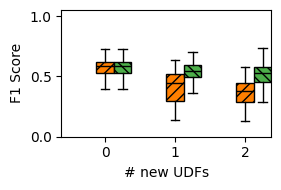

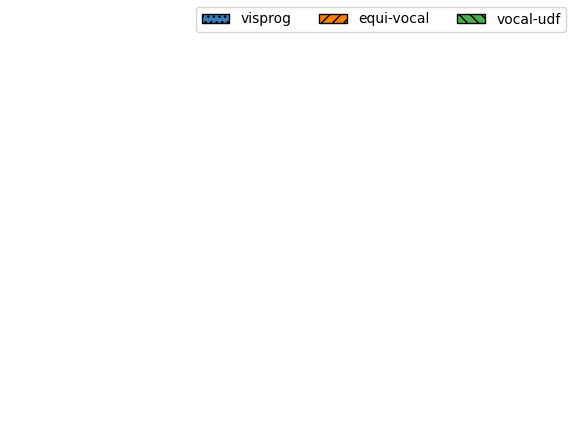

In [52]:
dataset = "cityflow"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
question_ids = list(range(20))
run_ids = list(range(1))
num_new_udfs = [0, 1, 2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

plot(dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

######## gpt-4-1106-preview ########
task_0_new_udfs_mean_f1: 0.9686245392484696
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.5198873284349611
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.3935364160428382
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.06025554477441301
task_3_new_udfs_prob_failures: 0.0

######## equi-vocal ########
task_0_new_udfs_mean_f1: 0.956079601423971
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.6520478385063007
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.46442971331277416
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.32567727611697317
task_3_new_udfs_prob_failures: 0.0

######## vocal-udf ########
task_0_new_udfs_mean_f1: 0.9426318003627053
task_0_new_udfs_prob_failures: 0.0

failed task: qid=3-run=1
task_1_new_udfs_mean_f1: 0.8026160221179811
task_1_new_udfs_prob_failures: 0.03333333333333333

task_2_new_udfs_mean_f1: 0.8073635928047479
task_2_new_udfs_pro

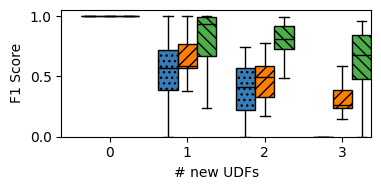

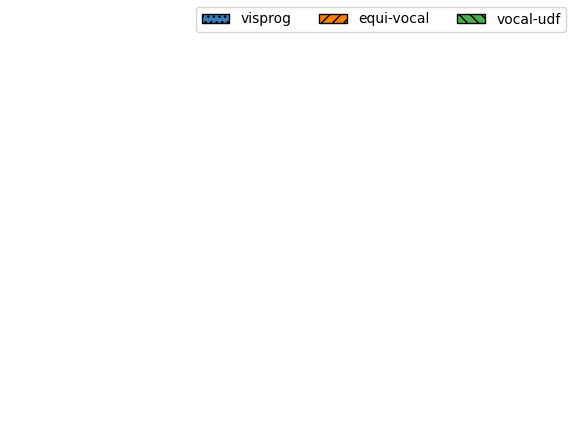

In [53]:
dataset = "clevrer"
query_class_names = [
    "3_new_udfs_labels",
]
question_ids = list(range(10))
run_ids = list(range(3))
num_new_udfs = [0, 1, 2, 3]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-labels=user-budget=20-llm_method=gpt4v"

plot(dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

######## gpt-4-1106-preview ########
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/charades/unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=0-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/charades/unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=1-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/charades/unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=2-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/logs/query_execution/charades/unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2/num_missing_udfs=0/visprog-llm=gpt-4-turbo-2024-04-09/qid=3-run=0.log'
[Errno 2] No such file or directory: '/gscratch/balazin

/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


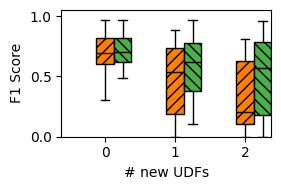

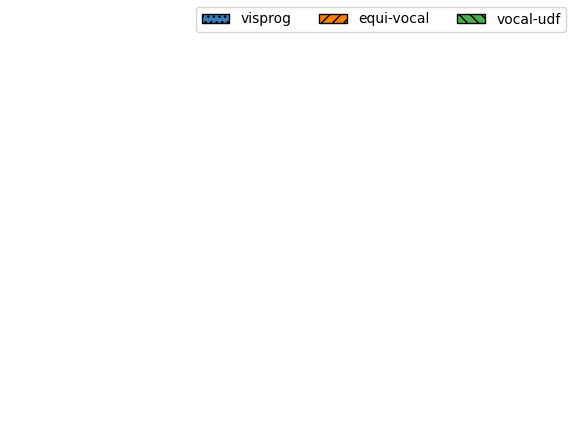

In [54]:
dataset = "charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
run_ids = list(range(1))
num_new_udfs = [0, 1, 2]
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-labels=user-budget=50-llm_method=gpt4v"

plot(dataset, query_class_names, num_new_udfs, question_ids, run_ids, vocal_udf_config_name)

######## gpt-4-1106-preview ########
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_0.json'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_1.json'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_2.json'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_3.json'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_4.json'
[Errno 2] No such file or directory: '/gscratch/balazinska/enhaoz/VOCAL-UDF/outputs/charades/gpt-4-1106-preview/task_1_new_udfs_labels_run_0_question_5.json'
[Errno 2] No su

/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/gscratch/balazinska/enhaoz/jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


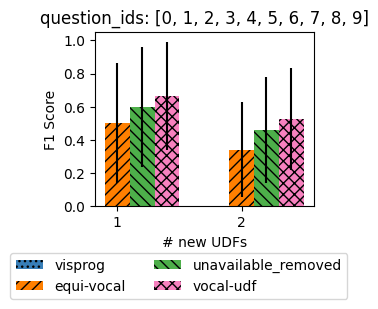

In [25]:
# Define LLM models, tasks, number of new UDFs, and hatch patterns
llm_models = ['gpt-4-1106-preview', 'equi-vocal', 'unavailable_removed', 'vocal-udf']
llm_model_labels = ['visprog', 'equi-vocal', 'unavailable_removed', 'vocal-udf']
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2", "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
    ]
tasks = [f"{i}_new_udfs" for i in range(1, 3)]
easy_question_ids = [0, 2, 4, 5, 7]
hard_question_ids = [1, 3, 6, 8, 9]
question_ids = sorted(easy_question_ids + hard_question_ids)
num_new_udfs = [1, 2]
# num_new_udfs = [0, 1]
hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
handles_f1 = []

# method_means = defaultdict(list)
# method_stds = defaultdict(list)

x = np.arange(len(tasks))  # the label locations
width = 1 / (len(llm_models) + 1) # the width of the bars
multiplier = 0

# Create a figure and axis for the boxplot
fig, ax = plt.subplots(1, 1, figsize=(3, 2.7))  # Adjust the figsize as needed

# Iterate through LLM models
for i, llm_model in enumerate(llm_models):
    print(f"######## {llm_model} ########")

    mean_list = []
    std_list = []

    # Iterate through tasks
    for task_id in range(1, 3):
        task = f"{task_id}_new_udfs"
        accuracy_list = []
        f1_list = []
        precision_list = []
        recall_list = []
        failed_list = []

        # Iterate through runs and questions
        if llm_model in ["unavailable_removed"]:
            if task_id != 0:
                for query_class_name in query_class_names:
                    for question_id in question_ids:
                        try:
                            with open(os.path.join(config['log_dir'], "query_execution", "charades", query_class_name, f"num_missing_udfs={task_id}", "queries_unavailable_udfs_removed", f"qid={question_id}.log"), "r") as f:
                                last_line = f.readlines()[-1]
                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                            match = re.search(f1_score_pattern, last_line)
                            f1_score = float(match.group(1))
                            f1_list.append(f1_score)
                        except Exception as e:
                            print(e)
                            continue

        elif llm_model in ["equi-vocal"]:
            if task_id != 0:
                for query_class_name in query_class_names:
                    for run_id in range(1):
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", "charades", query_class_name, f"num_missing_udfs={task_id}", llm_model, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    last_line = f.readlines()[-1]
                                f1_score_pattern = r"F1 score: ([0-9.]+)"
                                match = re.search(f1_score_pattern, last_line)
                                f1_score = float(match.group(1))
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

        elif llm_model in ['vocal-udf']:
            if task_id != 0:
                for query_class_name in query_class_names:
                    for run_id in range(1):
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", "charades", query_class_name, f"num_missing_udfs={task_id}", "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=100-selection=both-labels=user-budget=50-llm_method=gpt4v", f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    target_line = f.readlines()[-2]
                                f1_score_pattern = r"F1 score: ([0-9.]+)"
                                match = re.search(f1_score_pattern, target_line)
                                f1_score = 0
                                if match:
                                    f1_score = float(match.group(1))
                                    failed_list.append(0)
                                else:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                f1_list.append(f1_score)
                                accuracy_list.append(-1)
                                precision_list.append(-1)
                                recall_list.append(-1)
                            except Exception as e:
                                print(e)
                                continue
        else:
            for run_id in range(5):
                for question_id in question_ids:
                    try:
                        with open(os.path.join(config['output_dir'], "charades", llm_model, f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
                            data = json.load(f)
                        accuracy_list.append(data["accuracy"])
                        f1_list.append(data["f1"])
                        precision_list.append(data["precision"])
                        recall_list.append(data["recall"])
                        failed_list.append(data["failed"])
                        if '0' in task and data["failed"] > 0:
                            print(run_id, question_id)
                    except Exception as e:
                        print(e)
                        continue


        mean_list.append(np.mean(f1_list))
        std_list.append(np.std(f1_list))
        print(f"task_{task}_mean_accuracy: {np.mean(accuracy_list)}")
        print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
        print(f"task_{task}_mean_precision: {np.mean(precision_list)}")
        print(f"task_{task}_mean_recall: {np.mean(recall_list)}")
        print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
        print()

    offset = width * multiplier
    rects = ax.bar(x + offset, mean_list, width, yerr=std_list, label=llm_model_labels[i], color=CB_color_cycle[i], hatch=hatch_patterns[i])
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Customize the plot labels and legend
ax.set_title(f"question_ids: {question_ids}")
ax.set(ylabel="F1 Score")
ax.set(xlabel="# new UDFs")
ax.set_ylim(bottom=0, top=1.05)
# ax.set_xlim(left=-1.5)
ax.set_xticks(x + width, num_new_udfs)
# ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 0.5, len(llm_models) + 1))
# ax.set_xticklabels(num_new_udfs)
fig.legend(llm_model_labels, prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
           fancybox=True, shadow=False, ncol=2)
# fig.legend(handles_f1, llm_model_labels, prop={"size": 10}, loc='upper center', bbox_to_anchor=(0.5, 0.07),
#            fancybox=True, shadow=False, ncol=2)
plt.subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()

In [71]:
# Define LLM models, tasks, number of new UDFs, and hatch patterns
llm_models = ['vocal-udf', 'equi-vocal', 'unavailable_removed', 'gpt-4-1106-preview']
llm_model_labels = ['vocal-udf', 'equi-vocal', 'unavailable_removed', 'visprog']
task_name = "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2"
question_ids = list(range(10))
missing_udfs = [1, 2]

tuples = []
for question_id in question_ids:
    for mu in missing_udfs:
        tuples.append((f"Q{question_id}", f"missing={mu}"))
index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(0.0, index=llm_model_labels, columns=index)

# Iterate through LLM models
for i, llm_model in enumerate(llm_models):
    # Iterate through tasks
    for task_id in missing_udfs:
        # Iterate through runs and questions
        if llm_model in ["unavailable_removed"]:
            if task_id != 0:
                for question_id in question_ids:
                    try:
                        with open(os.path.join(config['log_dir'], "query_execution", "charades", task_name, f"num_missing_udfs={task_id}", "queries_unavailable_udfs_removed", f"qid={question_id}.log"), "r") as f:
                            last_line = f.readlines()[-1]
                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                        match = re.search(f1_score_pattern, last_line)
                        f1_score = float(match.group(1))
                        df.loc[llm_model_labels[i], (f"Q{question_id}", f"missing={task_id}")] = f1_score
                    except Exception as e:
                        print(e)
                        continue

        elif llm_model in ["equi-vocal"]:
            if task_id != 0:
                for question_id in question_ids:
                    f1_list = []
                    for run_id in range(3):
                        try:
                            with open(os.path.join(config['log_dir'], "query_execution", "charades", task_name, f"num_missing_udfs={task_id}", llm_model, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                last_line = f.readlines()[-1]
                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                            match = re.search(f1_score_pattern, last_line)
                            f1_score = float(match.group(1))
                            f1_list.append(f1_score)
                        except Exception as e:
                            print(e)
                            continue
                    df.loc[llm_model_labels[i], (f"Q{question_id}", f"missing={task_id}")] = np.mean(f1_list)

        elif llm_model in ['vocal-udf']:
            if task_id != 0:
                for question_id in question_ids:
                    f1_list = []
                    for run_id in range(3):
                        try:
                            with open(os.path.join(config['log_dir'], "query_execution", "charades", task_name, f"num_missing_udfs={task_id}", "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=100-selection=both-labels=user-budget=50-llm_method=gpt4v", f"qid={question_id}-run={run_id}.log"), "r") as f:
                                target_line = f.readlines()[-2]
                            f1_score_pattern = r"F1 score: ([0-9.]+)"
                            match = re.search(f1_score_pattern, target_line)
                            f1_score = float(match.group(1))
                            f1_list.append(f1_score)
                        except Exception as e:
                            print(e)
                            continue
                    df.loc[llm_model_labels[i], (f"Q{question_id}", f"missing={task_id}")] = np.mean(f1_list)
        # else:
        #     for run_id in range(5):
        #         for question_id in question_ids:
        #             try:
        #                 with open(os.path.join(config['output_dir'], "charades", llm_model, f"task_{task}_labels_run_{run_id}_question_{question_id}.json"), "r") as f:
        #                     data = json.load(f)
        #                 accuracy_list.append(data["accuracy"])
        #                 f1_list.append(data["f1"])
        #                 precision_list.append(data["precision"])
        #                 recall_list.append(data["recall"])
        #                 failed_list.append(data["failed"])
        #                 if '0' in task and data["failed"] > 0:
        #                     print(run_id, question_id)
        #             except Exception as e:
        #                 print(e)
        #                 continue

pd.options.display.float_format = '{:.3f}'.format

def highlight_max(s):
    is_max = s == s[:2].max()
    global_is_max = s == s.max()
    res = []
    for i in range(len(is_max)):
        style = ''
        if global_is_max.iloc[i]:
            style += 'font-weight:bold;'
        if is_max.iloc[i]:
            style += 'color: green;'
        res.append(style)
    return res

s = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
s.apply(highlight_max).format("{:.3f}")
